# Machine Learning Model of Hepatitis Domain

#### Finding Out:
- The living patients terminology prediction
- The die patients identified

#### Importing modules

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


#modeling
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, FeatureAgglomeration, OPTICS, Birch
from sklearn.linear_model import LogisticRegression, MultiTaskElasticNet, SGDClassifier, Perceptron
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB
from sklearn.neural_network import MLPClassifier

#Model Selection and Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import rand_score, adjusted_rand_score, mutual_info_score, adjusted_mutual_info_score, plot_confusion_matrix , homogeneity_score, completeness_score, v_measure_score, homogeneity_completeness_v_measure ,confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import Binarizer, StandardScaler, OneHotEncoder, Normalizer

#Composition and Pipeline Established
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

#Save the model 
import joblib

In [174]:
#MOdels in Lists
liner_models = [LogisticRegression(), SGDClassifier(), Perceptron(penalty='elasticnet')]
neighbors = [KNeighborsClassifier()]
trees = [DecisionTreeClassifier(), ExtraTreeClassifier()]
svc = SVC(kernel='sigmoid')
ensamples = [BaggingClassifier(), RandomForestClassifier(), ExtraTreesClassifier(), AdaBoostClassifier(), GradientBoostingClassifier()]
ensamples_stacking = StackingClassifier(estimators=[("perceptron",Perceptron(penalty='elasticnet')), ("GBC", GradientBoostingClassifier()), ('SGDC', SGDClassifier())])
ensamples_voting = VotingClassifier(estimators=[("perceptron",Perceptron(penalty='elasticnet')), ("GBC", GradientBoostingClassifier()), ('SGDC', SGDClassifier())])
gausian = GaussianProcessClassifier()
bayes = [BernoulliNB(), GaussianNB()]
nn_models = MLPClassifier(hidden_layer_sizes=50, activation='logistic', learning_rate='adaptive')

#### Reading the data

In [175]:
names = ["class_","age", "sex", "sterioid", "antivirals", "fatigue","malaise", "anorexia","liver_big", "liver_firm", "spleen_palable","spiders", "ascities", "varices", "bilirubin","alk_phosphate", "sgot", "albumin","prothtime", "histology"]
df = pd.read_csv("hepatitis.data", names=names, index_col=None, sep=",")
dataset = df.copy()
dataset.head(n=4)

,class_,age,sex,sterioid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palable,spiders,ascities,varices,bilirubin,alk_phosphate,sgot,albumin,prothtime,histology
0,2,30,2,1,2,2,2,2,1,2,2,2,2,2,1.00,85,18,4.0,?,1
1,2,50,1,1,2,1,2,2,1,2,2,2,2,2,0.90,135,42,3.5,?,1
2,2,78,1,2,2,1,2,2,2,2,2,2,2,2,0.70,96,32,4.0,?,1
3,2,31,1,?,1,2,2,2,2,2,2,2,2,2,0.70,46,52,4.0,80,1


In [176]:
df.columns

Index(['class_', 'age', 'sex', 'sterioid', 'antivirals', 'fatigue', 'malaise',
       'anorexia', 'liver_big', 'liver_firm', 'spleen_palable', 'spiders',
       'ascities', 'varices', 'bilirubin', 'alk_phosphate', 'sgot', 'albumin',
       'prothtime', 'histology'],
      dtype='object')

### Formatting Data for Model

In [177]:
df['class_'] = df['class_'].replace([1,2], ['Die', 'Live'])
df['sex'] = df['sex'].replace([1,2],['Male', 'Female'])
for col in ['class_', 'sex', 'sterioid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palable', 'spiders', 'ascities', 'varices', 'histology']:
    if df[col].dtype == 'O':
        df[col] = df[col].replace(['1','2'], ['No', 'Yes'])
    else:
        df[col] = df[col].replace([1,2], ['No', 'Yes'])

In [178]:
#"""df['class_'] = df['class_'].replace(['Die', 'Live'], [0,1])
#df['sex'] = df['sex'].replace(['Male', 'Female'], [0, 1])
#for col in ['class_', 'sex', 'sterioid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palable', 'spiders', 'ascities', 'varices', 'histology']:
#    df[col] = df[col].replace(['No', 'Yes'], [0, 1])"""

In [179]:
float_list = []
for column in df.columns:
    length = len(df[column].unique())
    if length > 3:
        float_list.append(column)

In [180]:
for col in float_list:
    df[col] = df[col].replace(['?'], [0])
    df[col] = df[col].astype("float64")

In [181]:
df.albumin.unique()

array([4. , 3.5, 0. , 4.4, 3.9, 3.7, 4.9, 2.9, 4.3, 4.1, 4.2, 4.7, 3.8,
       2.7, 4.6, 5. , 3.3, 4.5, 3.4, 3.1, 3. , 2.6, 5.3, 4.8, 2.8, 3.6,
       2.1, 6.4, 2.4, 2.2])

In [182]:
df.head()

,class_,age,sex,sterioid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palable,spiders,ascities,varices,bilirubin,alk_phosphate,sgot,albumin,prothtime,histology
0,Live,30.0,Female,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,1.0,85.0,18.0,4.0,0.0,No
1,Live,50.0,Male,No,Yes,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,0.9,135.0,42.0,3.5,0.0,No
2,Live,78.0,Male,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0.7,96.0,32.0,4.0,0.0,No
3,Live,31.0,Male,?,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0.7,46.0,52.0,4.0,80.0,No
4,Live,34.0,Male,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,1.0,0.0,200.0,4.0,0.0,No


In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   class_          155 non-null    object 
 1   age             155 non-null    float64
 2   sex             155 non-null    object 
 3   sterioid        155 non-null    object 
 4   antivirals      155 non-null    object 
 5   fatigue         155 non-null    object 
 6   malaise         155 non-null    object 
 7   anorexia        155 non-null    object 
 8   liver_big       155 non-null    object 
 9   liver_firm      155 non-null    object 
 10  spleen_palable  155 non-null    object 
 11  spiders         155 non-null    object 
 12  ascities        155 non-null    object 
 13  varices         155 non-null    object 
 14  bilirubin       155 non-null    float64
 15  alk_phosphate   155 non-null    float64
 16  sgot            155 non-null    float64
 17  albumin         155 non-null    flo

In [184]:
#df = df.fillna(value=0)
#for col in ['class_', 'sex', 'sterioid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palable', 'spiders', 'ascities', 'varices', 'histology']:
#    df[col] = df[col].astype("int64")

### Feature Selection and Label Identification

In [185]:
x_ = df.copy()
x = x_.drop(columns=["class_"]).copy()
x.shape

(155, 19)

In [186]:
y = df.class_.copy()
y = y.replace(['Die', 'Live'], [0, 1])
y = np.array(y)
y

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0], dtype=int64)

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   class_          155 non-null    object 
 1   age             155 non-null    float64
 2   sex             155 non-null    object 
 3   sterioid        155 non-null    object 
 4   antivirals      155 non-null    object 
 5   fatigue         155 non-null    object 
 6   malaise         155 non-null    object 
 7   anorexia        155 non-null    object 
 8   liver_big       155 non-null    object 
 9   liver_firm      155 non-null    object 
 10  spleen_palable  155 non-null    object 
 11  spiders         155 non-null    object 
 12  ascities        155 non-null    object 
 13  varices         155 non-null    object 
 14  bilirubin       155 non-null    float64
 15  alk_phosphate   155 non-null    float64
 16  sgot            155 non-null    float64
 17  albumin         155 non-null    flo

## Data Standerdization, Normalization, Best Data Selection, Splitting for Model and Test data

In [188]:
encode_cat_list = x.select_dtypes(include='object').columns
scale_float_list = x.select_dtypes(exclude='object').columns

In [189]:
encode_cat_list, scale_float_list

(Index(['sex', 'sterioid', 'antivirals', 'fatigue', 'malaise', 'anorexia',
        'liver_big', 'liver_firm', 'spleen_palable', 'spiders', 'ascities',
        'varices', 'histology'],
       dtype='object'),
 Index(['age', 'bilirubin', 'alk_phosphate', 'sgot', 'albumin', 'prothtime'], dtype='object'))

In [190]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             155 non-null    float64
 1   sex             155 non-null    object 
 2   sterioid        155 non-null    object 
 3   antivirals      155 non-null    object 
 4   fatigue         155 non-null    object 
 5   malaise         155 non-null    object 
 6   anorexia        155 non-null    object 
 7   liver_big       155 non-null    object 
 8   liver_firm      155 non-null    object 
 9   spleen_palable  155 non-null    object 
 10  spiders         155 non-null    object 
 11  ascities        155 non-null    object 
 12  varices         155 non-null    object 
 13  bilirubin       155 non-null    float64
 14  alk_phosphate   155 non-null    float64
 15  sgot            155 non-null    float64
 16  albumin         155 non-null    float64
 17  prothtime       155 non-null    flo

In [191]:
x_train,x_test, y_train,  y_test = train_test_split(x, y ,test_size=0.15, shuffle=True, random_state=10)

In [192]:
x_train.columns, x_test.shape

(Index(['age', 'sex', 'sterioid', 'antivirals', 'fatigue', 'malaise',
        'anorexia', 'liver_big', 'liver_firm', 'spleen_palable', 'spiders',
        'ascities', 'varices', 'bilirubin', 'alk_phosphate', 'sgot', 'albumin',
        'prothtime', 'histology'],
       dtype='object'),
 (24, 19))

In [193]:
scale = StandardScaler()
encode = OneHotEncoder()
norm = Normalizer()
best_select = SelectKBest(score_func=f_classif)
preprocess = ColumnTransformer(
    [
        ("scale", scale, scale_float_list ),
        ("norm", norm, scale_float_list),
        ("encode", encode, encode_cat_list)
    ]
)
def best_data_preprocess(features:np.matrix, labels:np.matrix):
    x_preprocess = preprocess.fit_transform(X=features, y=labels)
    x_preprocess = best_select.fit_transform(X=x_preprocess, y=labels)
    return x_preprocess

## Building Models

Model Name :Perceptron(penalty='elasticnet')
Precision :0.85
Recall :0.9444444444444444
Score :0.8333333333333334
F1 Score :0.8947368421052632


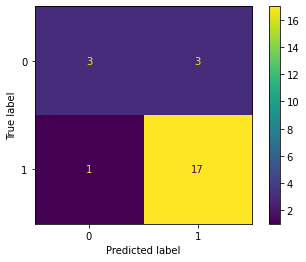

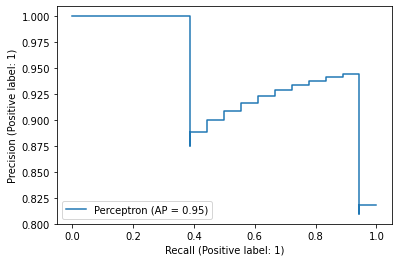

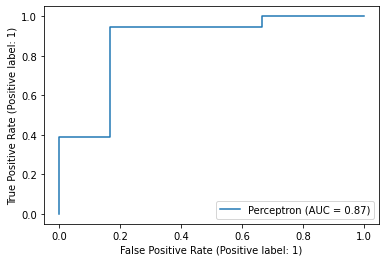

In [194]:
x_tr = best_data_preprocess(features=x_train, labels=y_train)
x_te = best_data_preprocess(features=x_test, labels=y_test)
models = [[gausian], liner_models, trees, [nn_models], ensamples, [ensamples_voting], [ensamples_stacking]]
m = []
for modeling in models:
    for model in modeling:
        model.fit(X=x_tr, y=y_train)
        y_pred = model.predict(x_te)
        precision = precision_score(y_true=y_test, y_pred=y_pred)
        score = model.score(X=x_te, y=y_test)
        recall = recall_score(y_true=y_test, y_pred=y_pred)
        f1_scor = f1_score(y_true=y_test, y_pred=y_pred)
        if precision > 0.8 and score > 0.8 and recall > 0.5:
            print(f"Model Name :{model}")
            print(f"Precision :{precision}")
            print(f"Recall :{recall}")
            print(f"Score :{score}")
            print(f"F1 Score :{f1_scor}")
            m.append(model)
for model in m:
    plot_confusion_matrix(model, X = x_te,y_true=y_test)
    plt.show()
    plot_precision_recall_curve(model,X=x_te,y=y_test)
    plt.show()
    plot_roc_curve(model,X=x_te,y=y_test)
    plt.show()



In [195]:
x_test.head()

,age,sex,sterioid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palable,spiders,ascities,varices,bilirubin,alk_phosphate,sgot,albumin,prothtime,histology
81,36.0,Male,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0.7,62.0,224.0,4.2,100.0,No
10,39.0,Male,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,1.3,78.0,30.0,4.4,85.0,No
90,50.0,Female,No,Yes,No,Yes,Yes,No,No,No,No,Yes,Yes,0.9,230.0,117.0,3.4,41.0,Yes
67,57.0,Male,Yes,Yes,No,No,No,Yes,Yes,Yes,No,No,Yes,4.1,0.0,48.0,2.6,73.0,No
55,37.0,Male,No,Yes,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,0.8,92.0,59.0,0.0,0.0,No


### Making a pipeline for Best model establishment

In [196]:
#Making A pipeline

final_model = Pipeline(steps=[('Preprocess',preprocess), ("Select Best",best_select), ("Model",m[0])])
final_model.fit(X=x_train, y=y_train)
final_model.predict(X=x_test)

array([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1], dtype=int64)

### Save the model

In [197]:
#Save the Model
joblib.dump(value=final_model, filename='model.json')

['model.json']

# Clustering Data

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 1 0 1 0 0 0 0 2 0 0 0 0 0 0]
0.6890193775689959 0.2127489605838886 0.04762695556882941 0.08870679287327521


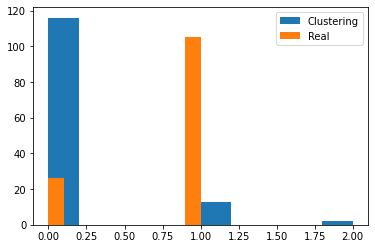

array([0, 1, 2], dtype=int64)

In [198]:
h1 = AgglomerativeClustering()
h2 = AffinityPropagation()
h3 = FeatureAgglomeration()
h4 = OPTICS()
h5 = Birch()

def model_selection(h1, data, true_clustered):
    x = data
    y = true_clustered
    h1.fit(x)
    print(h1.labels_)
    print(rand_score(labels_true=y, labels_pred=h1.labels_), adjusted_rand_score(y, h1.labels_), mutual_info_score(y, h1.labels_), adjusted_mutual_info_score(y, h1.labels_))
    plt.hist(x=h1.labels_, label='Clustering')
    plt.hist(x=y_train, label='Real')
    plt.legend()
    plt.show()
    return h1.labels_


x_train['cluster'] = model_selection(h5, data=x_tr, true_clustered=y_train)
x_train.cluster.unique()

